# Feature Matching
Feature matching involves comparing key attributes in different images to find similarities.

Feature matching is useful in many computer vision applications, including scene understanding, image stitching, object tracking, and pattern recognition.

https://www.youtube.com/playlist?list=PLSK7NtBWwmpR8VfRwSLrflmmthToXzTe_

## Brute-Force Search

In [1]:
!pip install opencv-python

In [2]:
import cv2
import numpy as np

### Brute Force with SIFT

In [3]:
sift = cv2.SIFT_create()

In [ ]:
#Find the keypoints and descriptors with SIFT.
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

#Find matches using k nearest neighbors.
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

#Apply ratio test to threshold the best matches.
good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append([m])

In [ ]:
#Draw the matches.
img3 = cv2.drawMatchesKnn(
    img1, kp1, img2, kp2, good, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

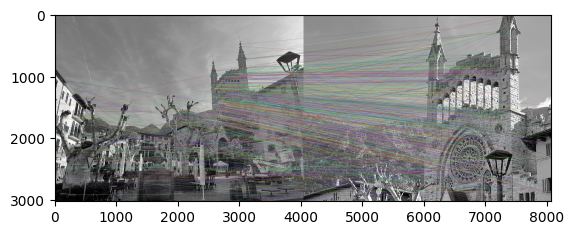

### Brute Force with ORB (binary) descriptors

In [ ]:
orb = cv2.ORB_create()

In [ ]:
#Find keypoints and descriptors.
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)


Because ORB is a binary descriptor, we find matches using **Hamming Distance**, which is a measure of the difference between two strings of equal length.

In [ ]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

#find the matches
matches = bf.match(des1, des2)

#sort by distance
matches = sorted(matches, key=lambda x: x.distance)

In [ ]:
#draw fisrt n matches
img3 = cv2.drawMatches(
    img1,
    kp1,
    img2,
    kp2,
    matches[:n],
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
)

### Fast Library for Approximate Nearest Neighbors (FLANN)

FLANN, or Fast Approximate Nearest Neighbors, introduced by Muja and Lowe, offers a solution akin to organizing a giant puzzle. Instead of laboriously attempting to match every piece, FLANN employs clever strategies to quickly identify pieces that likely fit together. Utilizing k-D trees, FLANN arranges puzzle pieces based on similar features, enabling rapid matching. It adapts its approach depending on the puzzle's characteristics, prioritizing color or shape features accordingly. This balance of speed and accuracy significantly enhances query efficiency.

In [ ]:
#create a dictionary to specify the algorithm we will use, for SIFT or SURF it looks like the following.
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)

In [ ]:
#For ORB, will use the parameters from the paper
FLANN_INDEX_LSH = 6
index_params = dict(
    algorithm=FLANN_INDEX_LSH, table_number=12, key_size=20, multi_probe_level=2
)

In [ ]:
#specify the maximum leafs to visit as follows.
search_params = dict(checks=50)

In [ ]:
#Initiate SIFT detector
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None) #Find the keypoints and descriptors with SIFT
kp2, des2 = sift.detectAndCompute(img2, None)

#define the FLANN parameters. Here, trees is the number of bins you want.
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1, des2, k=2)

In [ ]:
#only drawing good matches, so create a mask.
matchesMask = [[0, 0] for i in range(len(matches))]

#We can perform a ratio test to determine good matches
for i, (m, n) in enumerate(matches):
    if m.distance < 0.7 * n.distance:
        matchesMask[i] = [1, 0]

In [ ]:
#visualize the matches.
draw_params = dict(
    matchColor=(0, 255, 0),
    singlePointColor=(255, 0, 0),
    matchesMask=matchesMask,
    flags=cv2.DrawMatchesFlags_DEFAULT,
)

img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, matches, None, **draw_params)

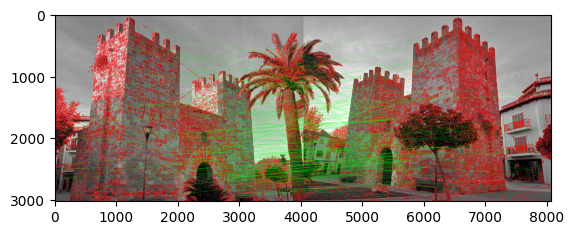

# Local Feature Matching with Transformers (LoFTR)

LoFTR was proposed in LoFTR: Detector-Free Local Feature Matching with Transformers by Sun, et. al. Instead of using feature detectors, LoFTR uses a learning-based approach to feature matching.

In [ ]:
#We can use Kornia to find matching features in two images using LoFTR
!pip install kornia  kornia-rs  kornia_moons opencv-python --upgrade

In [ ]:
import cv2
import kornia as K
import kornia.feature as KF
import matplotlib.pyplot as plt
import numpy as np
import torch
from kornia_moons.viz import draw_LAF_matches

In [ ]:
#Load and resize the images.
from kornia.feature import LoFTR

img1 = K.io.load_image(image1.jpg, K.io.ImageLoadType.RGB32)[None, ...]
img2 = K.io.load_image(image2.jpg, K.io.ImageLoadType.RGB32)[None, ...]

img1 = K.geometry.resize(img1, (512, 512), antialias=True)
img2 = K.geometry.resize(img2, (512, 512), antialias=True)


#Indicate whether the image is an “indoor” or “outdoor” image.
matcher = LoFTR(pretrained="outdoor")

In [ ]:
#LoFTR only works on grayscale images, so convert to images to grayscale.
input_dict = {
    "image0": K.color.rgb_to_grayscale(img1),
    "image1": K.color.rgb_to_grayscale(img2),
}

#perform the inference.
with torch.inference_mode():
    correspondences = matcher(input_dict)

#### Deal with noise and outliers in the data

In [ ]:
#Clean up the correspondences using Random Sample Consensus (RANSAC). This helps to deal with noise or outliers in the data.
mkpts0 = correspondences["keypoints0"].cpu().numpy()
mkpts1 = correspondences["keypoints1"].cpu().numpy()
Fm, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.5, 0.999, 100000)
inliers = inliers > 0

In [ ]:
#visualize the matches
draw_LAF_matches(
    KF.laf_from_center_scale_ori(
        torch.from_numpy(mkpts0).view(1, -1, 2),
        torch.ones(mkpts0.shape[0]).view(1, -1, 1, 1),
        torch.ones(mkpts0.shape[0]).view(1, -1, 1),
    ),
    KF.laf_from_center_scale_ori(
        torch.from_numpy(mkpts1).view(1, -1, 2),
        torch.ones(mkpts1.shape[0]).view(1, -1, 1, 1),
        torch.ones(mkpts1.shape[0]).view(1, -1, 1),
    ),
    torch.arange(mkpts0.shape[0]).view(-1, 1).repeat(1, 2),
    K.tensor_to_image(img1),
    K.tensor_to_image(img2),
    inliers,
    draw_dict={
        "inlier_color": (0.1, 1, 0.1, 0.5),
        "tentative_color": None,
        "feature_color": (0.2, 0.2, 1, 0.5),
        "vertical": False,
    },
)

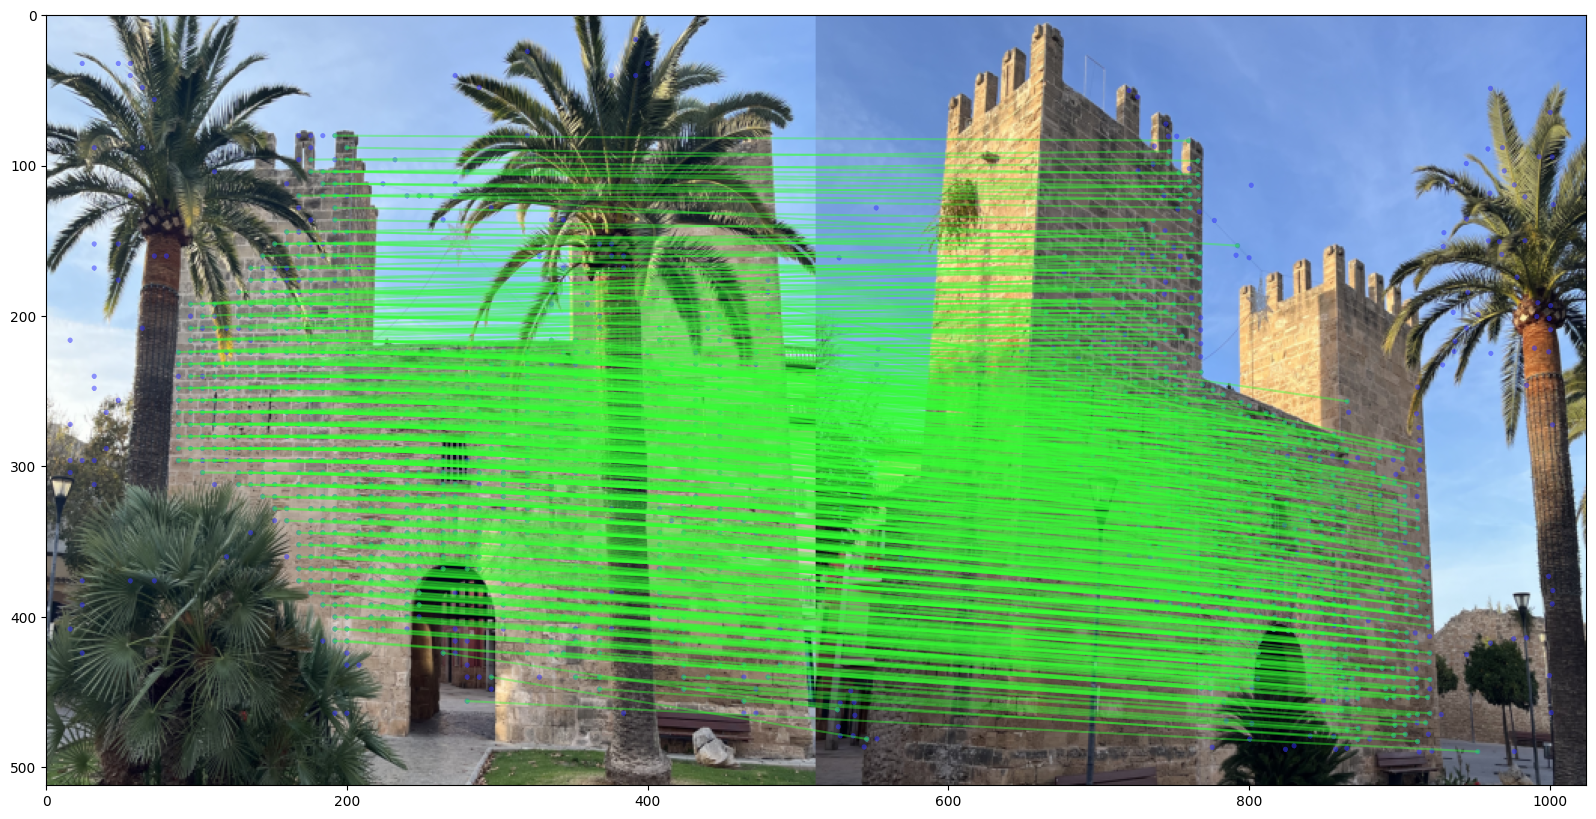